# Find the Murderer  

This project leverages graph theory and natural language processing (NLP) to analyze a complex story and predict the potential murderer. By utilizing techniques such as community detection, clustering, and NLP-driven text analysis, it identifies patterns and relationships within the narrative to narrow down the suspects.


---
<div align="center">
<center> Team Rasgulla Warriors </center>

| Name          | ID              |
|---------------|-----------------|
| Harsha V      | PES1UG22AM063   |
| Namita A      | PES1UG22AM100   |
| Shusrith S    | PES1UG22AM155   |
| Siddhi Z      | PES1UG22AM161   |

</div>

* [Github Repo](https://github.com/rasgulla-warriors/GitAwayWithMurder)
* [Dataset](https://www.gutenberg.org/cache/epub/69087/pg69087.txt)
* [SC Drive](https://drive.google.com/drive/folders/1TvlPiKdXrnY1jacNdW0AWfHKiH3AwB7B?usp=sharing)

---

## Importing all the necessary libraries

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict
from textblob import TextBlob
from collections import Counter
import community as community_louvain
import pandas as pd
from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

## Data

The data set for this work is taken from the novel **Murder of Roger Ackroyd**  by Agatha Christie.

### Why It's Suitable
- This classic Christie novel is renowned for its twist involving the identity of the murderer.  
- The novel is framed around a small number of characters in an intimate village, a perfect configuration for graph-based analysis.
- Many characters have possible motives. The relationships between the characters have to be understood to unfold the mystery.
- The book thus becomes a chance to create a character graph, evaluate the relationships and behavioral changes.

----

### Key Elements
- **Limited Suspects**: A manageable number of characters. Great analysis can take place for lots of crucial detail.
- **Complicated Interactions**: Lived to intricate relationships and motives, most of which are well hidden in the narrative.
- **Dynamics Mystery**: Great for community detection and clustering algorithm testing.  

----


The book was downloaded from the *Project Gutenberg* website, with its content in `.txt` format.

In [ ]:
!wget https://www.gutenberg.org/cache/epub/69087/pg69087.txt

--2024-11-22 03:58:47--  https://www.gutenberg.org/cache/epub/69087/pg69087.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 449339 (439K) [text/plain]
Saving to: ‘pg69087.txt.3’

pg69087.txt.3       100%[===================>] 438.81K  1.44MB/s    in 0.3s    

2024-11-22 03:58:48 (1.44 MB/s) - ‘pg69087.txt.3’ saved [449339/449339]



In [ ]:
path = '/content/pg69087.txt'
with open(f'{path}', 'r') as f:
    text = f.read()

## Extracting All Characters

To identify all the possible characters and interactions from the story, **Named Entity Recognition (NER)** was employed.  

### Observations and Challenges  
- **Garbage Values**: A few irrelevant values were detected but were ignored due to their minimal impact. These were handled during graph construction.
- **Character Variations**: Many characters appear in multiple formats like *\"M. Poirot\"* or *\"Poirot\"*. To deal with this:  - A dictionary-based solution was taken to normalize these variations into one entity: *\"Hercule Poirot\"*.  -

### Special Cases  -
- In the case of characters such as *Roger Ackroyd*, it became a bit tricky because their names overlap in others, e.g., *\"Flora Ackroyd\"*.
- A **named mapping** was thus created to ensure that identification and normalization did not hurt the other related characters.

### Character Interactions Extraction

Character interactions between the characters were extracted following the approach below:

1. **Sentence-Level Character Identification**: The code identifies, at each sentence, entities labeled with *PERSON* by means of NER.
2. **Normalization**: Using the `name_mapping` dictionary, character names are normalized to ensure consistency across different formats for the same character.
3. **Generating character pairs**: For each sentence, generate all possible pairs of characters by considering their co-occurrence in that sentence.
4. **Recording Interactions**: Store the interactions between each pair of characters in a dictionary called `interactions`, where the key is a tuple of character names and the value is a list of sentences in which they both appear.

This process enables capturing and storing all relevant interactions between characters in the story for more detailed analysis.



In [ ]:
# Load NLP model
nlp = spacy.load("en_core_web_sm")

# Process text
doc = nlp(text)

# Extract character names
characters = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
character_counts = Counter(characters)

In [ ]:
print(character_counts)

Counter({'Poirot': 309, 'Ackroyd': 261, 'Caroline': 180, 'Flora': 135, 'Ralph': 105, 'Blunt': 100, 'Ralph Paton': 72, 'Raymond': 71, 'Sheppard': 62, 'M. Poirot': 57, 'Ferrars': 48, 'Project Gutenberg': 48, 'Raglan': 47, 'Miss Russell': 45, 'Parker': 44, 'James': 36, 'Roger': 29, 'Miss Ganett': 28, 'Paton': 23, 'Roger Ackroyd': 21, 'Ganett': 21, 'Miss Ackroyd': 21, 'Flora Ackroyd': 19, 'Melrose': 17, 'Hammond': 16, 'Ursula Bourne': 16, 'Geoffrey Raymond': 15, 'Russell': 13, 'Kent': 13, 'Charles Kent': 12, 'Davis': 10, 'Mademoiselle Flora': 10, 'Carter': 10, 'Mah Jong': 9, 'Ellerby': 9, 'Ralph Paton’s': 8, 'Ralph\nPaton': 7, 'Whistle': 7, 'Hercule Poirot': 6, 'Hastings': 6, 'Hector Blunt': 6, 'Annie': 5, 'Porrott': 5, 'M. Raymond': 5, 'Elsie Dale': 5, 'Gutenberg': 5, 'Elsie': 4, 'bien': 4, 'Folliott': 4, 'Ashley Ferrars': 3, 'Cecil Ackroyd': 3, 'Floss': 3, '\\': 3, 'Geoffrey': 3, 'M.\nPoirot': 3, 'Papa Poirot': 3, 'Mademoiselle Caroline': 3, 'Chow': 3, 'Captain Paton': 3, 'Fate': 2, 'Abb

In [ ]:
name_mapping = {
    "M. Ackroyd": "Roger Ackroyd",
    "Ackroyd": "Roger Ackroyd",
    "Ackroyd.—9.45": "Roger Ackroyd",
    "Ralph Paton's": "Ralph Paton",
    "Ralph\nPaton": "Ralph Paton",
}

normalized_characters = [name_mapping.get(char, char) for char in characters]

# Counting character occurrences
character_counts = Counter(normalized_characters)

l = []
for key, value in character_counts.items():
    if ('poirot' or 'hercule') in key.lower():
        character_counts['Hercule Poirot'] += value
        l.append(key)
    elif 'gutenberg' in key.lower():
        character_counts['Gutenberg'] += value
        l.append(key)

for key in l:
    del character_counts[key]

In [ ]:
interactions = defaultdict(list)

for sent in doc.sents:
    characters_in_sent = [ent.text for ent in sent.ents if ent.label_ == "PERSON"]

    # Normalizing character names using the `name_mapping` dictionary
    normalized_characters_in_sent = [name_mapping.get(char, char) for char in characters_in_sent]

    # Creating all possible pairs of characters in the sentence
    for i, char1 in enumerate(normalized_characters_in_sent):
        for char2 in normalized_characters_in_sent[i+1:]:
            # Append it to the dictionary
            interactions[(char1, char2)].append(sent.text)

# Converting defaultdict to a standard dictionary for easier manipulation, if needed
interactions = dict(interactions)

## Creation and Analysis using graphs

### Graph Construction and Analysis

Construction process initiated with the creation of a graph in which nodes would symbolize characters and edges interactions, extracted using **Named Entity Recognition (NER)** with additional filtering. On plotting this graph, we noticed a tightly packed cluster of nodes; thus, we zeroed in on these nodes for further analysis.

### Refining the Graph

We then further filtered this in terms of **degree centrality** in order to make the graph clearer and more relevant. We thus set a threshold, removed nodes whose degree centrality is below this threshold, and ended up with a very much refined graph.

### Community Detection

Next, we applied **Girvan-Newman** community detection to pick out clusters of close-related nodes. After analyzing the graph, one large community emerged, which we separated by removing all the other small communities, enhancing our final graph.

### Eliminating Redundant Nodes

However, even after the filtering and community detection steps, the nodes of some still represented the same character. Most probably, this was because NER sometimes failed to extract differences in names in a character name quite accurately. We merged redundant nodes and edges. This was most necessary for characters like *Poirot*, *Roger Ackroyd*, *Flora Ackroyd*, *Ralph Paton*, and *Geoffery Raymond*.


In [ ]:
# Creating a graph
G = nx.Graph()

# Adding nodes for each character
for character in set([char for pair in interactions.keys() for char in pair]):
    G.add_node(character)

# Adding edges
for (char1, char2), sentences in interactions.items():
    G.add_edge(char1, char2, weight=len(sentences))

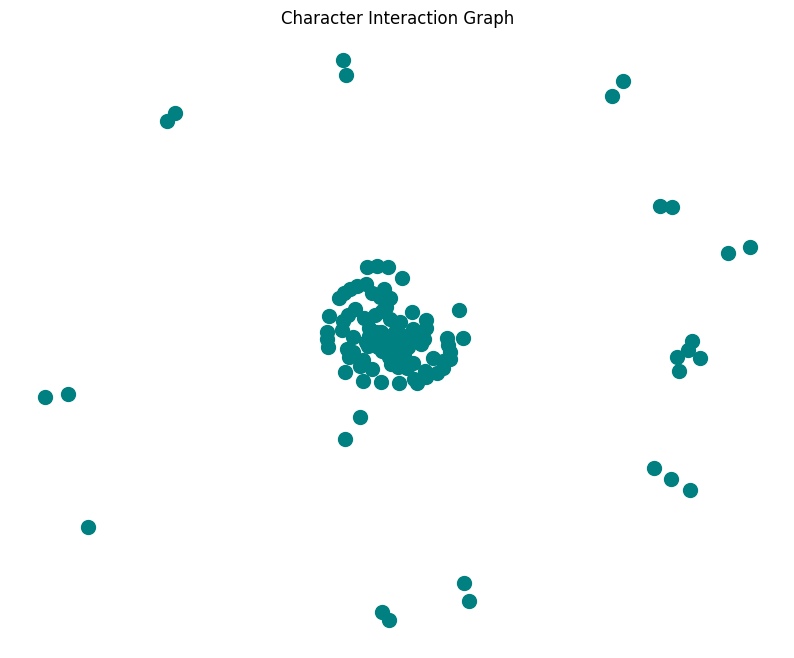

In [ ]:
# Visualization without using any of the edges
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='teal')

# Show the plot
plt.title("Character Interaction Graph")
plt.axis('off')  # Hide axis
plt.show()

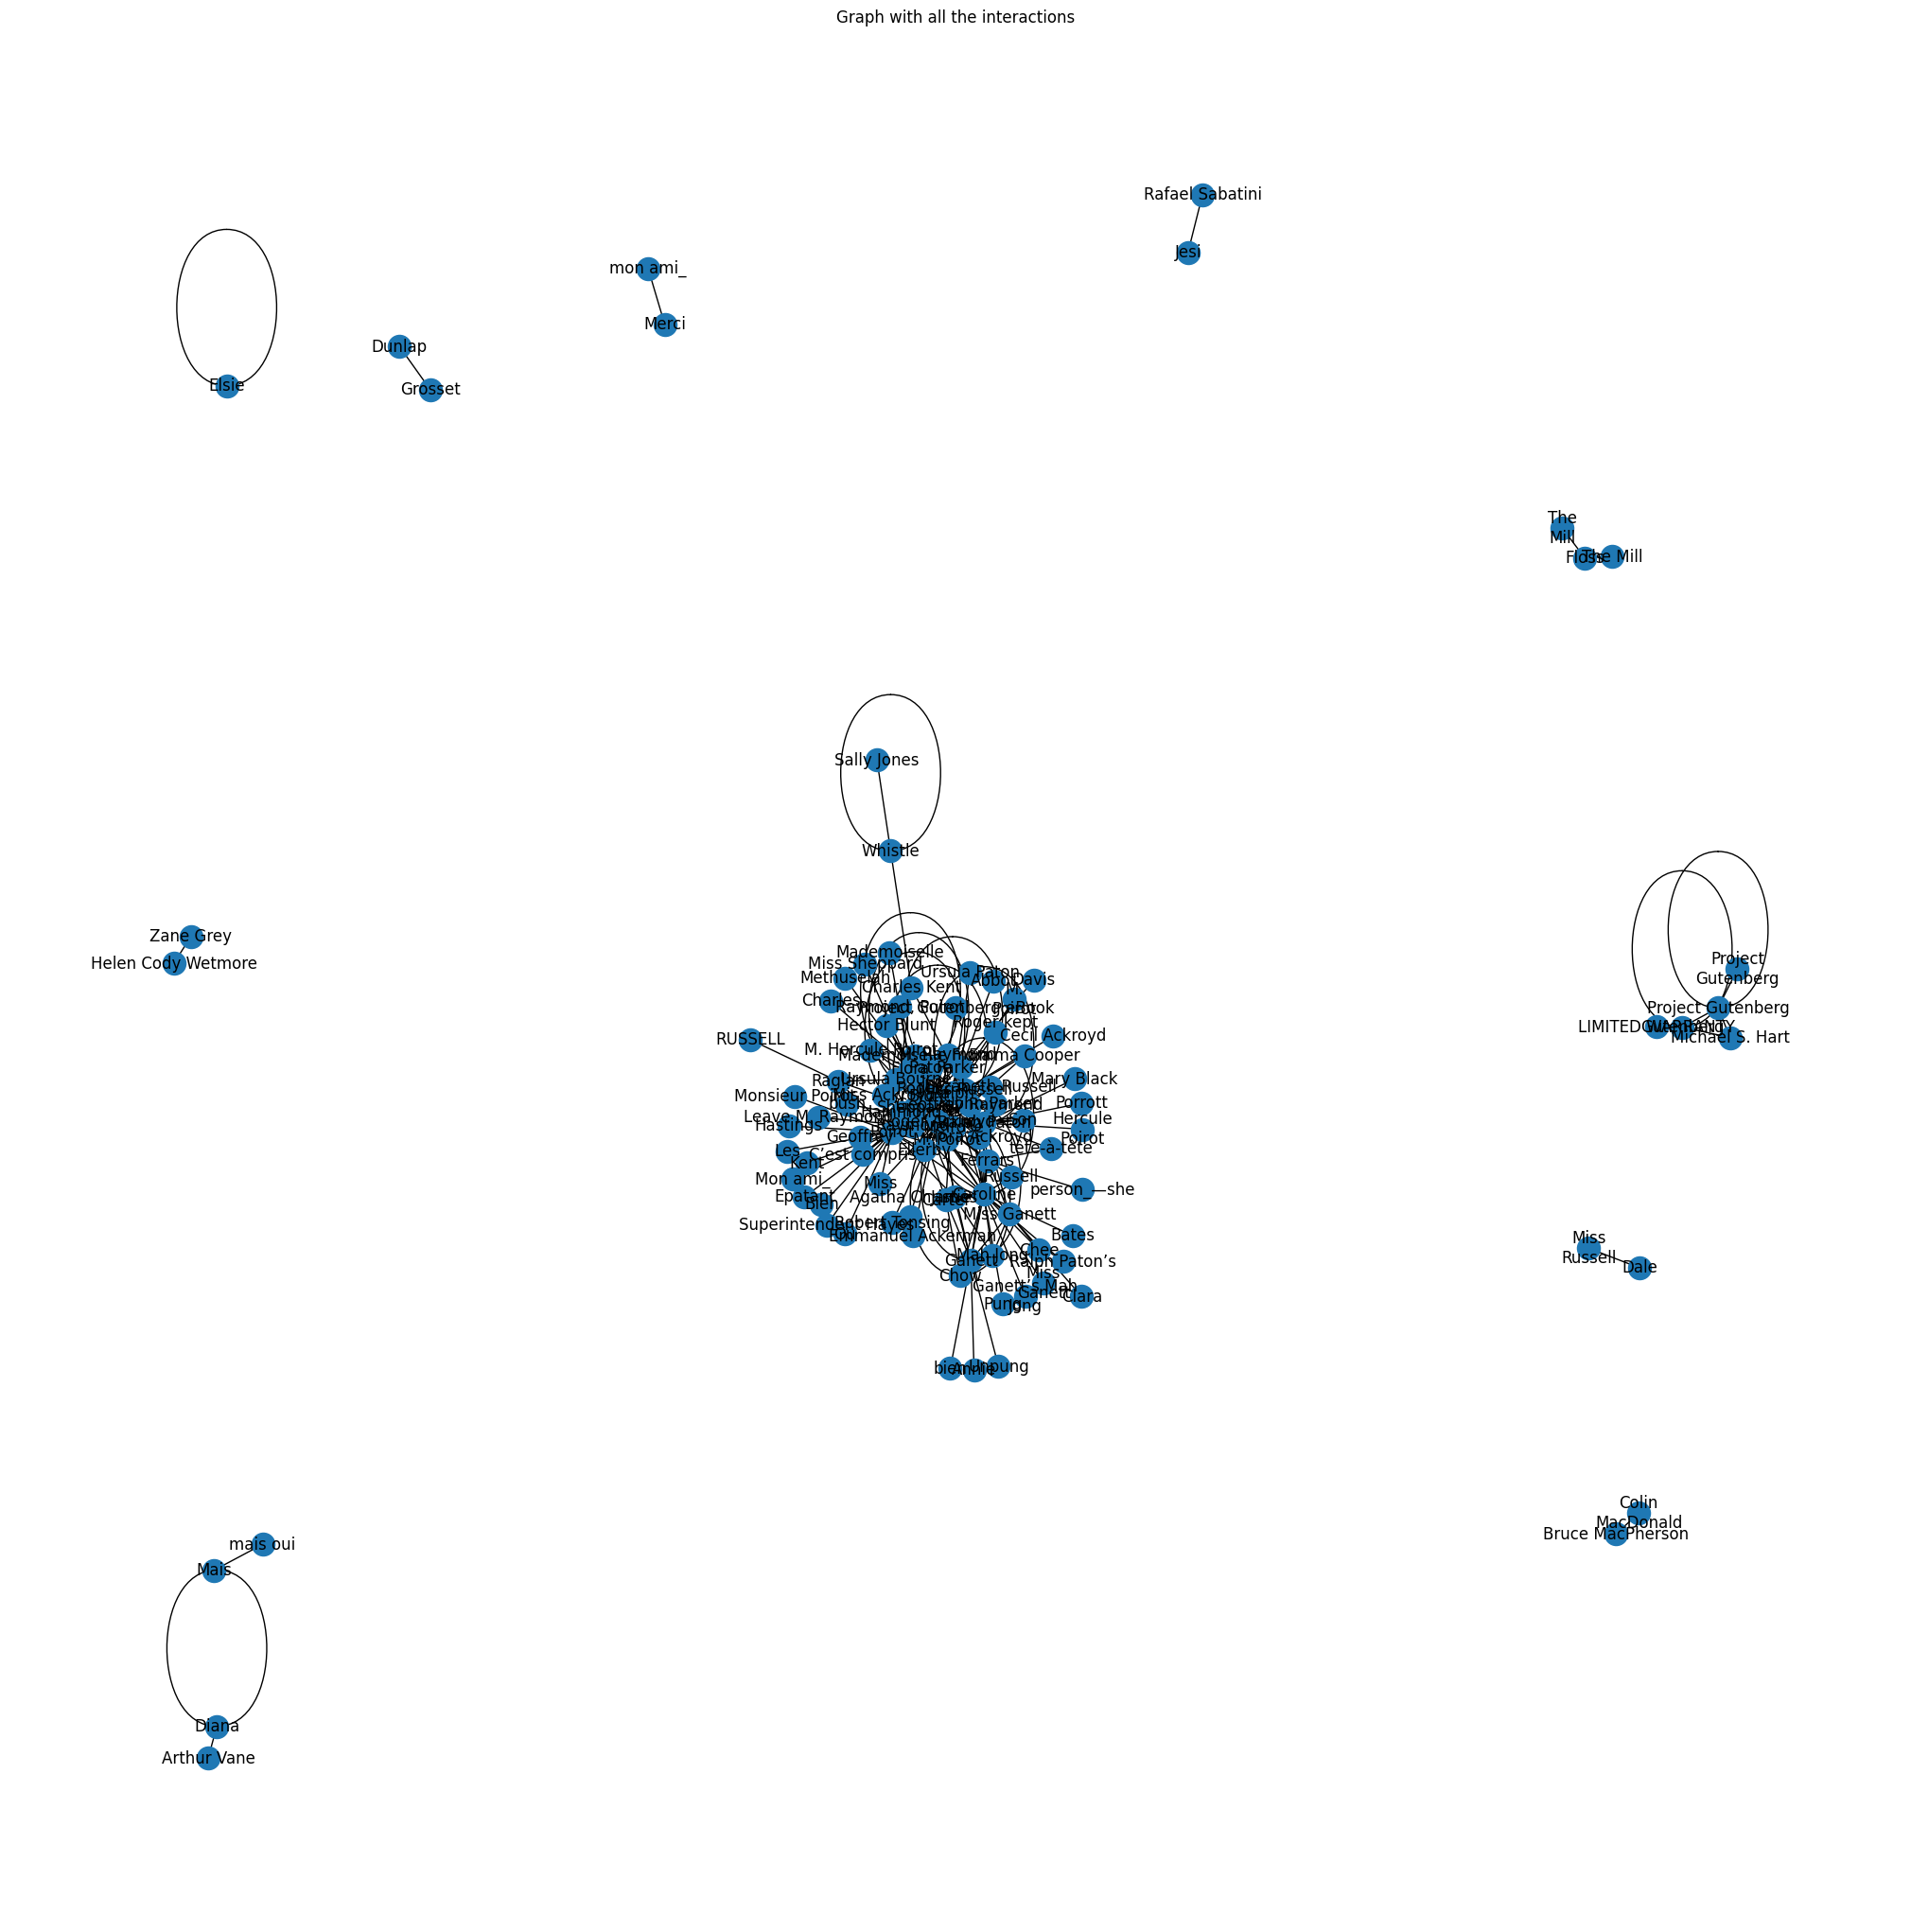

In [ ]:
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True)
plt.title("Graph with all the interactions")
plt.show()

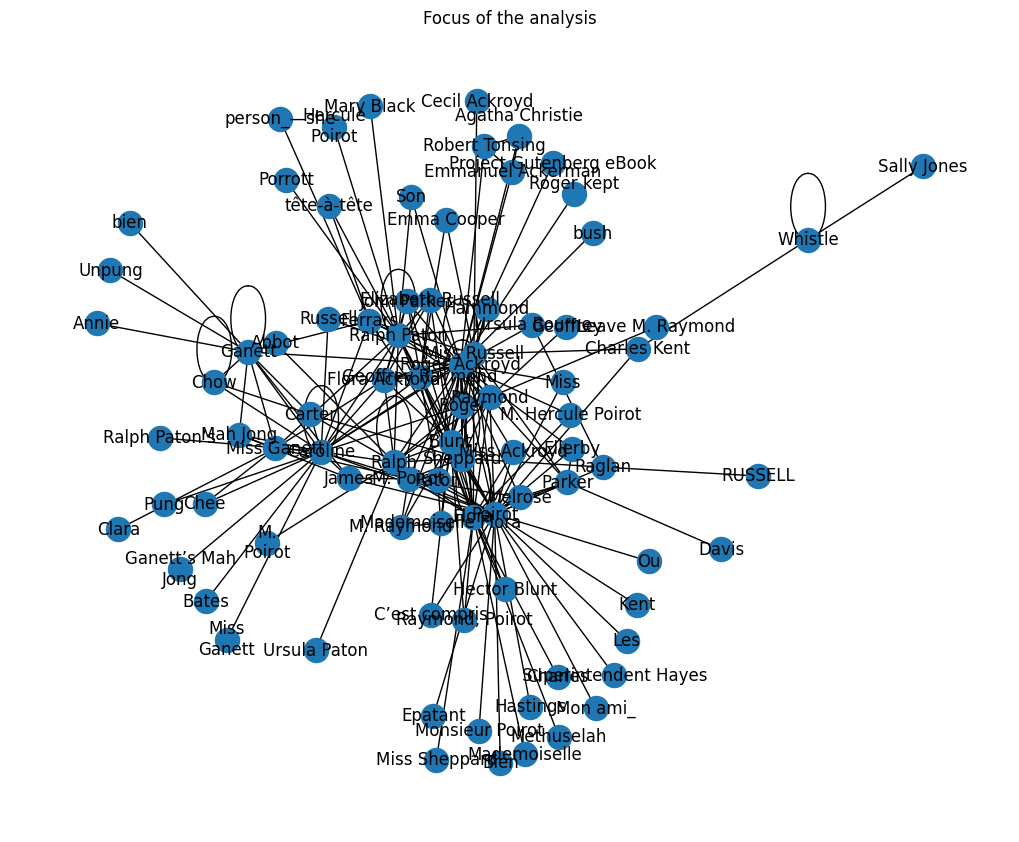

In [ ]:
# Getting largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Creating a subgraph containing only the largest connected component
G_connected = G.subgraph(largest_cc).copy()

# Viewing the graph clearly
plt.figure(figsize=(10,8))
nx.draw(G_connected, with_labels=True)
plt.title("Focus of the analysis")
plt.show()

In [ ]:
degree_centrality = nx.degree_centrality(G_connected)

df_centrality = pd.DataFrame(degree_centrality.items(), columns=["Node", "Degree Centrality"])

# Sorting by centrality
df_centrality = df_centrality.sort_values(by="Degree Centrality", ascending=False).reset_index(drop=True)

print(df_centrality)

             Node  Degree Centrality
0   Roger Ackroyd           0.447059
1          Poirot           0.364706
2        Caroline           0.294118
3           Flora           0.258824
4     Ralph Paton           0.247059
..            ...                ...
81           Kent           0.011765
82          Abbot           0.011765
83        RUSSELL           0.011765
84  Miss Sheppard           0.011765
85       Hastings           0.011765

[86 rows x 2 columns]


In [ ]:
threshold = 0.06

# Filtering out all the nodes that are below the threshold
nodes_to_keep = df_centrality[df_centrality["Degree Centrality"] >= threshold]["Node"].tolist()

# Creating a new graph
G_new = G_connected.subgraph(nodes_to_keep).copy()

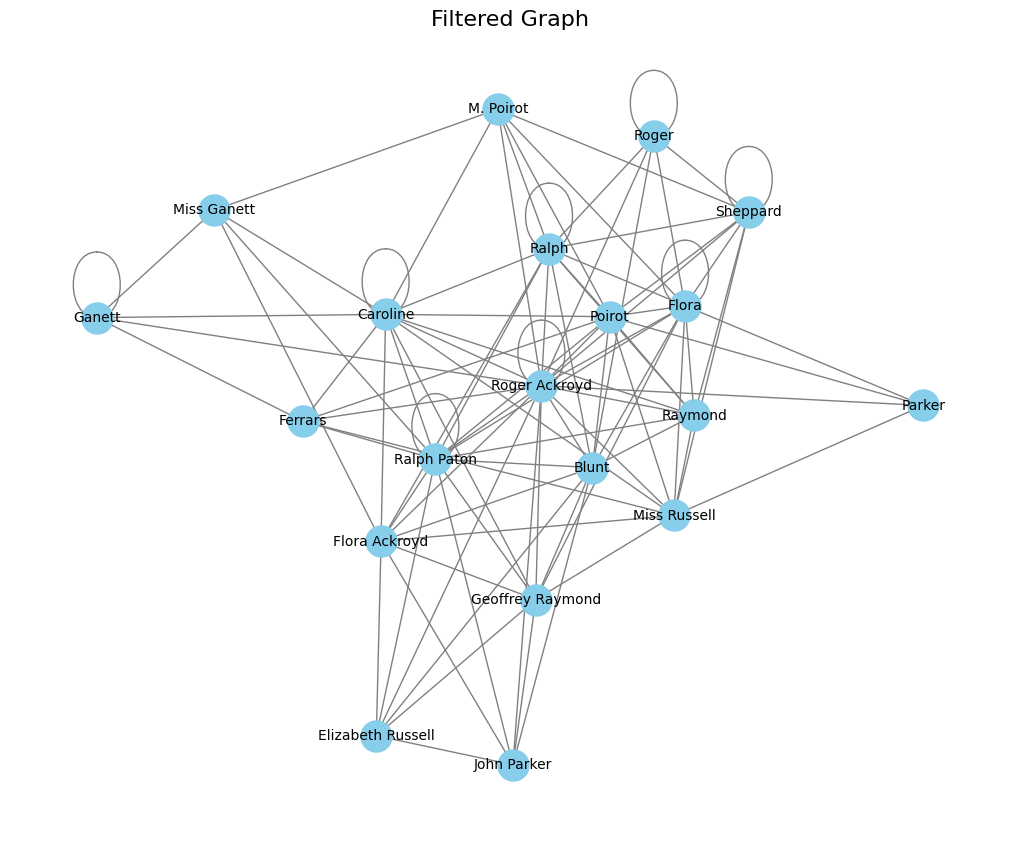

In [ ]:
#Visualizing
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_new)
nx.draw(G_new, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=10)
plt.title("Filtered Graph", fontsize=16)
plt.show()

In [ ]:
from networkx.algorithms.community import girvan_newman
def girvan_newman_communities(graph, num_communities):
    comp_gen = girvan_newman(graph)
    for i, communities in enumerate(comp_gen):
        if len(communities) == num_communities:
            return [list(community) for community in communities]

num_communities = 5

communities = girvan_newman_communities(G_new, num_communities)

for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

Community 1: ['Caroline', 'Ferrars', 'Ralph', 'Miss Russell', 'Roger', 'Blunt', 'Raymond', 'Flora', 'Geoffrey Raymond', 'Sheppard', 'Ralph Paton', 'Roger Ackroyd', 'M. Poirot', 'John Parker', 'Flora Ackroyd', 'Poirot']
Community 2: ['Parker']
Community 3: ['Ganett']
Community 4: ['Elizabeth Russell']
Community 5: ['Miss Ganett']


In [ ]:
import matplotlib.colors as mcolors

def plot_girvan_newman_communities(graph, communities):
    pos = nx.spring_layout(graph)
    color_map = list(mcolors.TABLEAU_COLORS.values())
    node_colors = {}

    for i, community in enumerate(communities):
        color = color_map[i % len(color_map)]
        for node in community:
            node_colors[node] = color

    node_list = list(node_colors.keys())
    node_color_list = [node_colors[node] for node in node_list]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(graph, pos, nodelist=node_list, node_color=node_color_list, node_size=300)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos)

    plt.title("Communities Detected by Girvan-Newman Algorithm")
    plt.show()

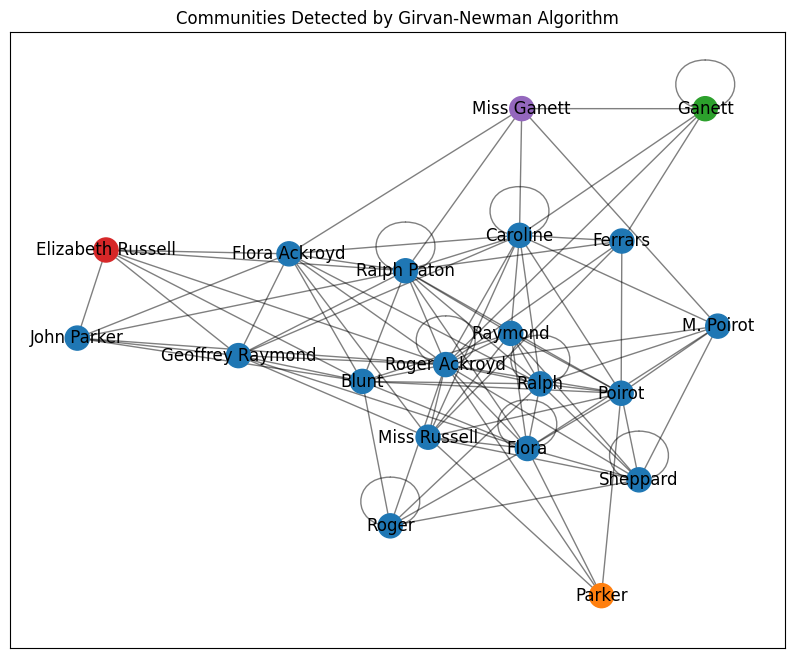

In [ ]:
plot_girvan_newman_communities(G_new, communities)

In [ ]:
# Nodes to remove: Combine all nodes from communities 2, 3, 4, and 5
# This was manually removed since we have just a few nodes to be removed. This could be otherwise done using the communities with their indices being iterated over.
nodes_to_remove = ['Parker', 'Ganett', 'Elizabeth Russell', 'Miss Ganett']

# Remove the nodes from the graph
G_new.remove_nodes_from(nodes_to_remove)

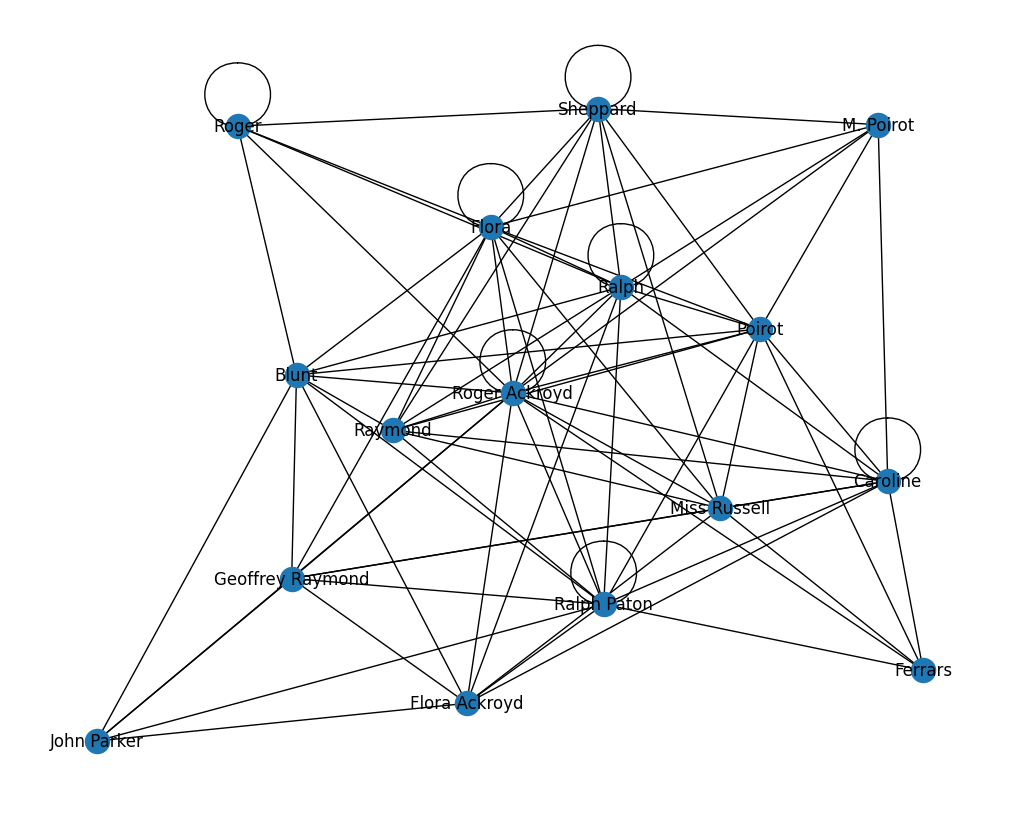

In [ ]:
plt.figure(figsize=(10,8))
nx.draw(G_new, with_labels=True)
plt.show()

In [ ]:
# Mapping of nodes to combine: {primary_node: [nodes_to_merge]}
merge_mapping = {
    "Roger Ackroyd": ["Roger"],
    "Flora Ackroyd": ["Flora"],
    "Poirot": ["M. Poirot"],
    "Ralph Paton": ["Ralph"],
    "Sheppard": ["James"],
    "Geoffrey Raymond": ["Raymond"]
}

def combine_nodes(graph, merge_mapping):
    for primary_node, nodes_to_merge in merge_mapping.items():
        for node in nodes_to_merge:
            if graph.has_node(node):
                # Redirecting edges from `node` to `primary_node`
                for neighbor in list(graph.neighbors(node)):
                    if neighbor != primary_node:
                        graph.add_edge(primary_node, neighbor)
                # Remove the `node`
                graph.remove_node(node)
    return graph

G_new = combine_nodes(G_new, merge_mapping)

# Printiing this shows us that the number of nodes and edges have reduced
print(f"Updated graph has {G_new.number_of_nodes()} nodes and {G_new.number_of_edges()} edges.")

Updated graph has 11 nodes and 45 edges.


## Final Graph

After such refinements, we were left with a graph that captured the crux of the story, representing the key characters and their interactions in readiness for deeper analysis.

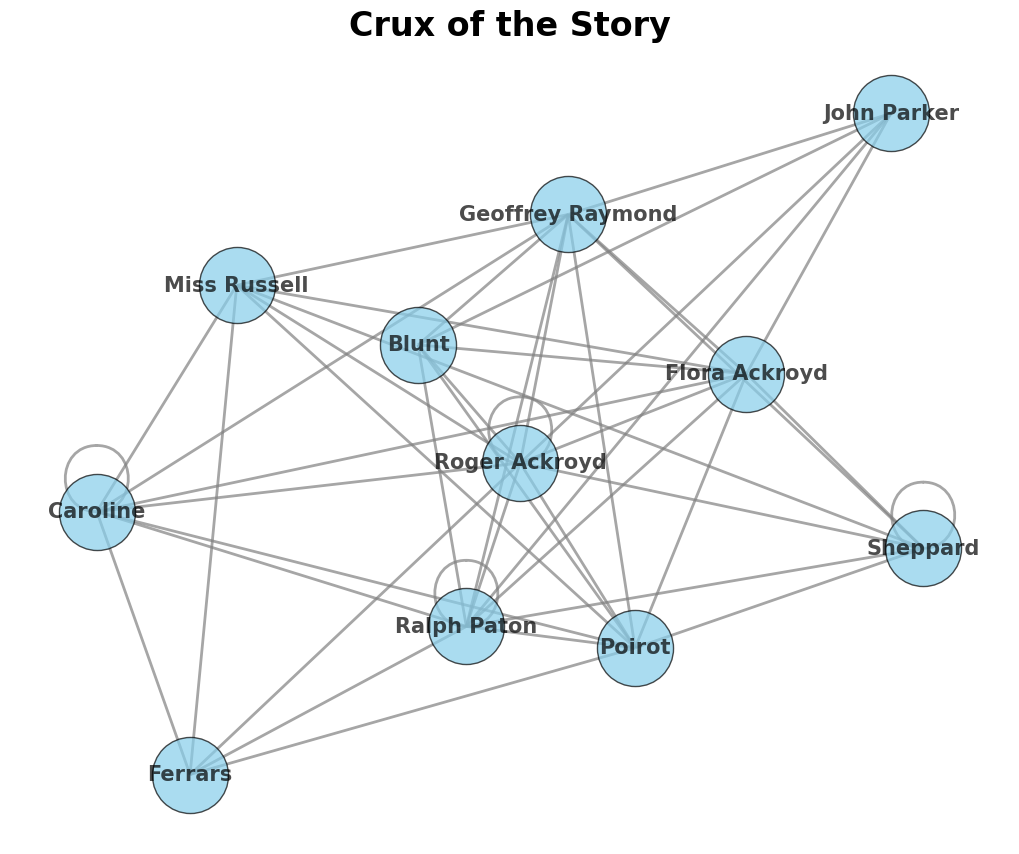

In [ ]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G_new, seed=42)
nx.draw(G_new, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, font_weight='bold', edge_color='gray', width=2, alpha=0.7, edgecolors='black')
plt.title("Crux of the Story", fontsize=24, fontweight='bold')
plt.axis('off')
plt.show()

## Finding the potential murderer

### 1. **Feature Extraction**


- **Sentiment**: The sentiment from interactions between characters is calculated using **TextBlob**. The sentiment scores are aggregated for every character to obtain an average sentiment score.
Degree Centrality: The degree centrality is computed for each character on the interaction graph, indicating how each character is connected to others in the network.
- Proximity to Victim: This feature captures the degree to which each character is connected to other characters who are close to the victim, **Roger Ackroyd**.
- **Suspicious Keywords**: Characters using, repeatedly, any of the threat words, angry words, revenge words, and jealous words such as "threatened", "angry", "kill", etc are suspect.
These features are appended as attributes to each node in the interaction graph.

### 2. **Feature Vector Creation**
Each character is represented by a feature vector containing the following attributes:
- **Degree Centrality**
- **Average Sentiment**
- **Proximity to Victim**
- **Number of Suspicious Keywords**

We then accumulate these vectors into a **NumPy array** to make processing easier.

### 3. **Feature Standardization**
We apply **StandardScaler** to standardize the features so that the data is normalized. This is necessary because **K-Means clustering** is sensitive to the scale of features and may be biased by outliers.

### 4. **Clustering**
We apply **K-Means clustering** to the feature vectors to group characters into clusters. After doing the clustering, we plot the clusters and pay special attention to smaller clusters that might contain suspicious characters.

### 5. Outlier Analysis
The smaller cluster that might contain suspects is analyzed further. We rank the nodes (characters) in this cluster based on **their closeness centrality**, which measures how closely connected a character is to other important nodes in the network. This ranking forms the **suspicion score**.


In [ ]:
# Function to extract sentiment of interactions using TextBlob
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity  # Negative values are negative sentiment, positive is positive

In [ ]:
# Calculating degree centrality for each character
degree_centrality = nx.degree_centrality(G_new)

# Calculating the sentiment of each interaction and aggregate it per character
character_sentiment = defaultdict(list)

for (char1, char2), sentences in interactions.items():
    for sentence in sentences:
        sentiment = get_sentiment(sentence)
        character_sentiment[char1].append(sentiment)
        character_sentiment[char2].append(sentiment)

# Mean sentiment
character_avg_sentiment = {char: sum(sentiments) / len(sentiments) if sentiments else 0
                           for char, sentiments in character_sentiment.items()}

In [ ]:
# Calculating the proximity of each character to the victim
victim = 'Roger Ackroyd'
victim_interactions = {char: sum([1 for (c1, c2) in interactions.keys() if c1 == char or c2 == char])
                       for char in G_new.nodes()}

# Hardcoding some suspicious keywords and checking if any of the characters are related to these
keywords = ["threatened", "angry", "kill", "revenge", "jealousy"]
character_keywords = defaultdict(list)

for (char1, char2), sentences in interactions.items():
    for sentence in sentences:
        for keyword in keywords:
            if keyword in sentence.lower():
                character_keywords[char1].append(keyword)
                character_keywords[char2].append(keyword)

In [ ]:
# Adding features as attributes to nodes in the graph
for character in G_new.nodes():
    G_new.nodes[character]['degree_centrality'] = degree_centrality.get(character, 0)
    G_new.nodes[character]['average_sentiment'] = character_avg_sentiment.get(character, 0)
    G_new.nodes[character]['proximity_to_victim'] = victim_interactions.get(character, 0)
    G_new.nodes[character]['suspicious_keywords'] = character_keywords.get(character, [])


features = []

# Feature vectors for clustering
for character in G_new.nodes():
    features.append([
        G_new.nodes[character].get('degree_centrality', 0),
        G_new.nodes[character].get('average_sentiment', 0),
        G_new.nodes[character].get('proximity_to_victim', 0),
        len(G_new.nodes[character].get('suspicious_keywords', []))  # Number of suspicious keywords
    ])

# Simple conversion to a NumPy array
features = np.array(features)

# Normalizing/Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Clustering via K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# Cluster labels as node attributes
for idx, character in enumerate(G_new.nodes()):
    G_new.nodes[character]['cluster'] = labels[idx]


# Displaying the clusters
cluster_groups = defaultdict(list)
for idx, character in enumerate(G_new.nodes()):
    cluster_groups[labels[idx]].append(character)


for cluster_id, characters in cluster_groups.items():
    print(f"Cluster {cluster_id}: {', '.join(characters)}")

Cluster 0: Geoffrey Raymond, Roger Ackroyd, Caroline, Blunt, Ralph Paton, Flora Ackroyd, Poirot
Cluster 1: John Parker, Ferrars, Miss Russell, Sheppard


In [ ]:
# Analyzing the smaller cluster (the one with potential murderers)
outlier_cluster = min(cluster_groups, key=lambda k: len(cluster_groups[k]))  # Smallest cluster
print(f"Outlier Cluster (potential murderer): {', '.join(cluster_groups[outlier_cluster])}")

Outlier Cluster (potential murderer): John Parker, Ferrars, Miss Russell, Sheppard


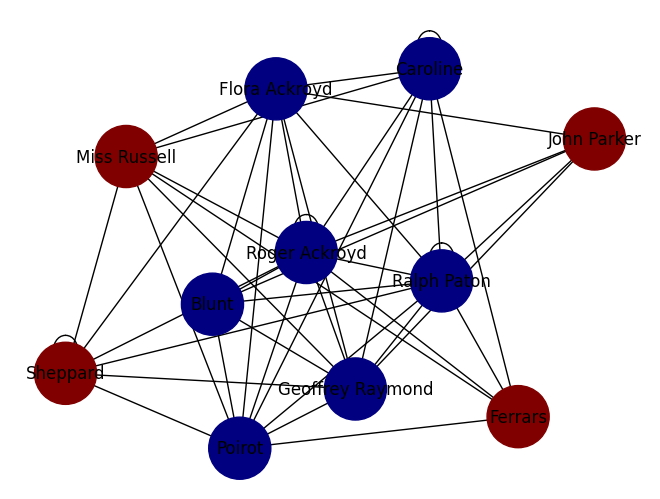

In [ ]:
# Visualizing
pos = nx.spring_layout(G_new)
colors = [labels[list(G_new.nodes()).index(character)] for character in G_new.nodes()]
nx.draw(G_new, pos, with_labels=True, node_color=colors, cmap=plt.cm.jet, node_size=2000, font_size=12)
plt.show()

**WE OBSERVE THE MURDERER (SHEPPARD) TO BE A PART OF THE POTENTIAL MURDERERS**

In [ ]:
# Ranking outlier characters based on their features, including closeness centrality
def rank_by_suspicion(outlier_cluster):
    character_scores = {}

    for character in outlier_cluster:
        # Retrieving the character's features
        degree_centrality = G_new.nodes[character].get('degree_centrality', 0)
        closeness_centrality_score = nx.closeness_centrality(G_new, character)  # Closeness centrality
        avg_sentiment = G_new.nodes[character].get('average_sentiment', 0)
        proximity_to_victim = G_new.nodes[character].get('proximity_to_victim', 0)
        suspicious_keywords_count = len(G_new.nodes[character].get('suspicious_keywords', []))

        # Calculating a suspicion score
        suspicion_score = (degree_centrality * 0.2) + (closeness_centrality_score * 0.4) + \
                          (avg_sentiment * -0.4) + (proximity_to_victim * 0.3) + \
                          (suspicious_keywords_count * 0.5)

        character_scores[character] = suspicion_score

    # Sorting it to find who is the most possible to have murdered the victim
    ranked_characters = sorted(character_scores.items(), key=lambda x: x[1], reverse=True)

    return ranked_characters

# Ranking characters in the outlier cluster
ranked_characters = rank_by_suspicion(cluster_groups[outlier_cluster])

print("Ranked Suspicious Characters (Potential Murderer at the Top):")
for rank, (character, score) in enumerate(ranked_characters, start=1):
    print(f"Rank {rank}: {character} (Suspicion Score: {score:.2f})")

Ranked Suspicious Characters (Potential Murderer at the Top):
Rank 1: Miss Russell (Suspicion Score: 5.21)
Rank 2: Sheppard (Suspicion Score: 4.60)
Rank 3: Ferrars (Suspicion Score: 3.05)
Rank 4: John Parker (Suspicion Score: 2.14)


## Result

- **Miss Russell** is at the top of the suspicion ranking, and the second highest ranked person after **James Sheppard**, who is the murderer in the story itself.

### Reason for Results
With the complexity and complexity of the tale, the analysis does not fully grapple with the essence of the story, thus missing some true interpretations on who the murderer is. However, the analysis still offers vivid ideas concerning suspect characters, culminating in the identification of **James Sheppard** as the murderer despite the complexity of the plot.

---
## Future Work

- **Preprocessing**: Further refinement of the character feature extraction process might include better capturing character relationships and interactions, perhaps in areas of ambiguous interactions or refinement of sentiment analysis models.
- **Graph Neural Networks (GNNs)**: In the future, **Graph Neural Networks (GNNs)** can be used to predict a potential murderer by more effectively learning the relations between characters and the roles that they play in the story for improved prediction accuracy through consideration of the graph structure.